In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt

In [12]:
def read_triangles(tau, scale, gamma, ndata=100, nstart=100, nstop=20000, nstep=100):
    
    folder = "gamma-"+str(gamma)+"/scale-"+str(scale)+"/ple-"+str(tau)
    
    x = np.arange(nstart, nstop+1, nstep)
    y = np.array([])
    y_full = {}
    for n in range(nstart, nstop+1, nstep):
    
        file = open(folder+"/n-"+str(n)+".txt","r")
        
        temp = np.array([])
        i = 0
        while i < ndata:
            try:
                temp = np.append(temp, float(file.readline().split()[-1]))
                i += 1
            except:
                break
        file.close()
        
        y = np.append(y, np.mean(temp))
        
        temp = np.sort(temp)
        y_full[n] = temp
    return x, y, y_full


def real_exponent(tau):
    if tau > 7/3:
        rex = 1
    if tau < 7/3:
        rex = ((3-tau)/2)*3
    
    return rex


def func(x, a, b):
    return a*(x**b)


def fitting_curve(x, y, rex=None, tail=30):
    
    tail_len = (len(x)*tail)//100
    def real_func(x, a):
        return a*(x**rex)
    
    if rex:
        (C, ), err = opt.curve_fit(real_func, x[-tail_len:], y[-tail_len:])
        z = [C*(x0**rex) for x0 in x]
        ex = rex
    
    else:
        (C, ex), err = opt.curve_fit(func, x[-tail_len:], y[-tail_len:])
        z = [C*(x0**ex) for x0 in x]
    
    return z, (C, ex)


def graphic_exponent(tau, scale, gamma, ndata=100, nstart=100, nstop=10000, nstep=100):
    
    x, y, y_full = read_triangles(tau, scale, gamma, ndata=ndata, nstart=nstart, nstop=nstop, nstep=nstep)
    
    tails = np.array([])
    exps = np.array([])
        
    for opt_tail in range(25,101,1):
        
        z, (C, exp) = fitting_curve(x, y, tail=opt_tail)
        
        tails = np.append(tails, opt_tail)
        exps = np.append(exps, exp)

    rex = real_exponent(tau)
    rexps = np.ones(len(tails))*rex
        
    title = f"TAU = {tau} | SCALE = {scale} | DIMENSION = {1} | GAMMA = {2}\n"
    str_info = f"number of nodes up to {nstop}"
    fig, ax1 = plt.subplots(1, 1, figsize=(15,5));
    fig.suptitle(str(title)+str_info);
    ax1.plot(tails, exps, label="Approx. exponent");
    ax1.plot(tails, rexps, label="Theory exponent");
    ax1.plot(tails[list(tails).index(50)],exps[list(tails).index(50)], "ro")
    ax1.legend();
    ax1.invert_xaxis()
    ax1.set_ylabel("Exponent value")
    ax1.set_xlabel("% of tail used for fitting")
    ax1.set_ylim([rex-.1, rex+.1])
    return
        

def graphic_data(tau, scale, gamma, graph=True, scaletype="normal", gtype="normal", graph_range=None, save=False, ndata=100, nstart=100, nstop=20000, nstep=100, opt_tail=30):
    
    x, y, y_full = read_triangles(tau, scale, gamma, ndata=ndata, nstart=nstart, nstop=nstop, nstep=nstep)
    
    rex = real_exponent(tau)
    
    z, (C, ex) = fitting_curve(x, y, rex, tail=opt_tail)
        
    rex = format(rex, '.3f')
    C = format(C, '.3f')
    ex = format(ex, '.3f')    
    
    if graph:
                
        #title = f"TAU = {tau} | DIMENSION = {1} | GAMMA = {2}\n"
        #str_info = f"ASYMPTOTIC CURVE EXPONENT: {rex}"
        #fig.suptitle(str(title)+str_info);
        
        plt.figure(figsize=(12,8));
        
        if scaletype=="normal":
            plt.plot(x, z, "b-", label="Expected asymptotic behaviour");
        elif scaletype=="loglog":
            plt.loglog(x, z, "b-", label="Expected asymptotic behaviour");
        
        if graph_range:
            new_x = []
            new_y = []
            for i, x0 in enumerate(x):
                if x0 in graph_range:
                    new_x.append(x0)
                    new_y.append(y[i])
            x = new_x
            y = new_y
            
        if scaletype=="normal":
            plt.plot(x, y, "ro", ms=8, label="Average number of triangles");
        elif scaletype=="loglog":
            plt.loglog(x, y, "ro", ms=8, label="Average number of triangles");
        
        min_index = (y_full[x[0]].size//10) - 1
        max_index = -(y_full[x[0]].size//10)
        
        if gtype=="CI":
            for x0 in x:
                plt.vlines(x0, y_full[x0][min_index], y_full[x0][max_index], colors=(0,0,0,0.5), linewidth=3);
                plt.plot(x0, y_full[x0][min_index], c="black", marker="_", ms=8);
                plt.plot(x0, y_full[x0][max_index], c="black", marker="_", ms=8);

        elif gtype=="CIfill":
            y_up = []
            y_down = []
            for x0 in x:
                y_up.append(y_full[x0][max_index])
                y_down.append(y_full[x0][min_index])
            plt.fill_between(x, y_down, y_up, color="red", alpha=0.3);
        
        plt.ylabel("Number of triangles", fontsize=25);
        plt.xlabel("Number of nodes", fontsize=25);
        plt.xticks(fontsize=20);
        plt.yticks(fontsize=20);
        plt.legend(fontsize=25);
    
    if save=="default":
        plt.savefig(str(tau)+".png");
    
    elif save!=False:
        plt.savefig(save+".png");
    
    return x, y, z, float(ex)


def multi_graphic_data(tau, scale, gammas, graph=True, scaletype="normal", graph_range=None, save=False, ndata=100, nstart=100, nstop=20000, nstep=100, opt_tail=30):
    
    rex = real_exponent(tau)
    colors = ["C0","C1","C2","C3","C4","C5","C6","C7","C8","C9"]
    
    x = {}
    y = {}
    y_full = {}
    z = {}
    color = {}
    
    for i, gamma in enumerate(gammas):
        x[gamma], y[gamma], y_full[gamma] = read_triangles(tau, scale, gamma, ndata=ndata, nstart=nstart, nstop=nstop, nstep=nstep)
        z[gamma], (C,ex) = fitting_curve(x[gamma], y[gamma], rex, tail=opt_tail)
        color[gamma] = colors[i]
            
    if graph:
        
        plt.figure(figsize=(12,8));
        
        if scaletype=="normal":
            for gamma in gammas:
                plt.plot(x[gamma], z[gamma], "k-");
        elif scaletype=="loglog":
            for gamma in gammas:
                plt.loglog(x[gamma], z[gamma], "k-");
        
        if graph_range:
            new_x = {}
            new_y = {}
            for gamma in gammas:    
                new_x[gamma] = []
                new_y[gamma] = []
                for i, x0 in enumerate(x[gamma]):
                    if x0 in graph_range:
                        new_x[gamma].append(x0)
                        new_y[gamma].append(y[gamma][i])
                x[gamma] = new_x[gamma]
                y[gamma] = new_y[gamma]

        if scaletype=="normal":
            for gamma in gammas:
                plt.plot(x[gamma], y[gamma], "o", color=color[gamma], ms=8, label=r"$\gamma = $"+str(gamma));
        elif scaletype=="loglog":
            for gamma in gammas:
                plt.loglog(x[gamma], y[gamma], "o", color=color[gamma], ms=8, label=r"$\gamma = $"+str(gamma));
        
        min_index = (y_full[gammas[0]][x[gammas[0]][0]].size//10) - 1
        max_index = -(y_full[gammas[0]][x[gammas[0]][0]].size//10)
    

        y_up = {}
        y_down = {}
        for gamma in gammas:
            y_up[gamma] = []
            y_down[gamma] = []
            
            for x0 in x[gamma]:
                y_up[gamma].append(y_full[gamma][x0][max_index])
                y_down[gamma].append(y_full[gamma][x0][min_index])
            plt.fill_between(x[gamma], y_down[gamma], y_up[gamma], color=color[gamma], alpha=0.3);
        
        plt.ylabel("Number of triangles", fontsize=35);
        plt.xlabel("Number of vertices", fontsize=35);
        plt.xticks(fontsize=20);
        plt.yticks(fontsize=20);
        plt.legend(fontsize=20);
        plt.tight_layout();
    
    if save=="default":
        plt.savefig(str(tau)+".png");
    
    elif save!=False:
        plt.savefig(save+".png");
    
    return

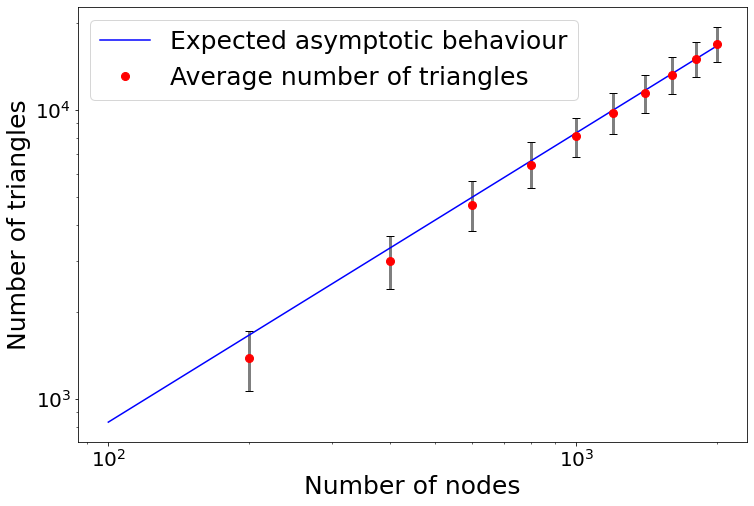

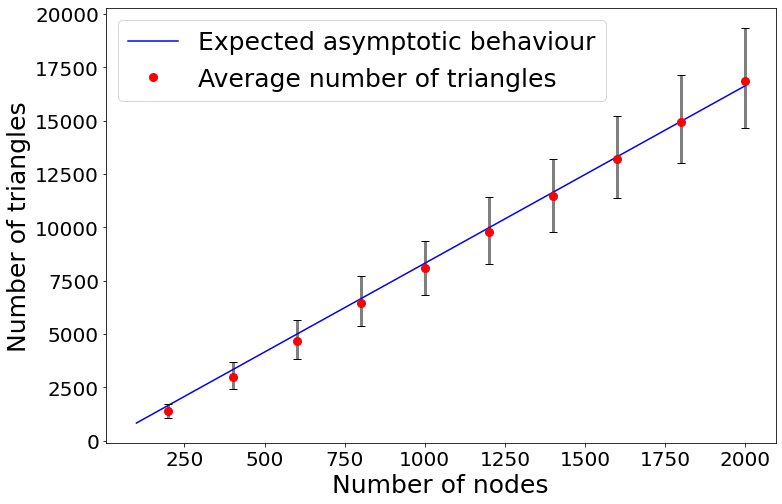

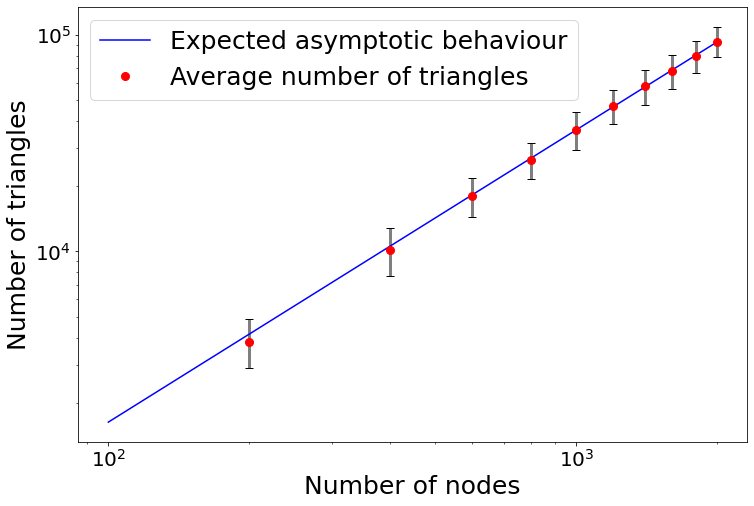

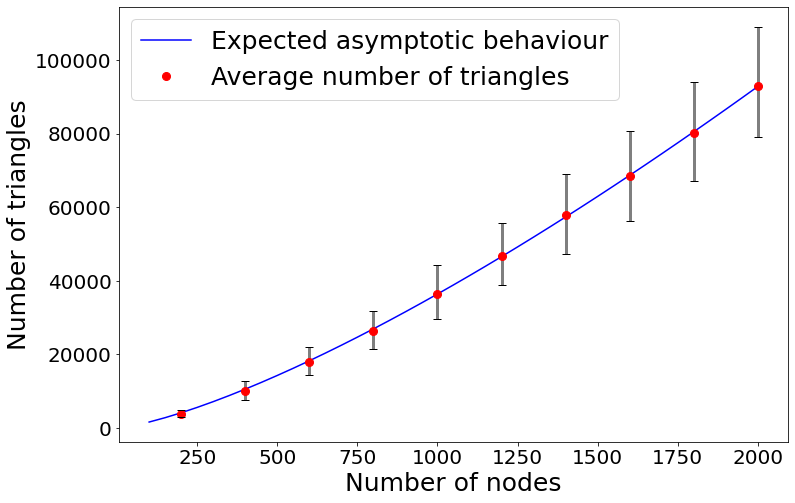

In [14]:
graphic_data(2.7, 1.0, gtype="CI", scaletype="loglog", ndata=500, nstart=100, nstop=2000, nstep=50, graph_range=list(range(200,2001,200)));
graphic_data(2.7, 1.0, gtype="CI", scaletype="normal", ndata=500, nstart=100, nstop=2000, nstep=50, graph_range=list(range(200,2001,200)));

graphic_data(2.1, 1.0, gtype="CI", scaletype="loglog", ndata=500, nstart=100, nstop=2000, nstep=50, graph_range=list(range(200,2001,200)));
graphic_data(2.1, 1.0, gtype="CI", scaletype="normal", ndata=500, nstart=100, nstop=2000, nstep=50, graph_range=list(range(200,2001,200)));


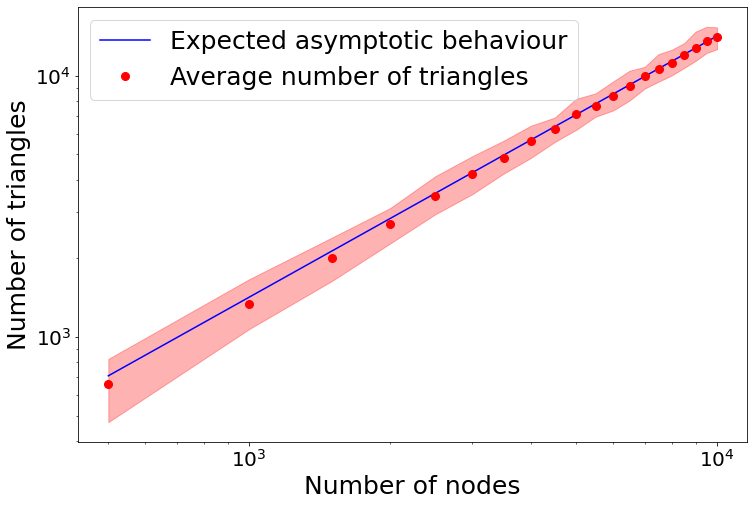

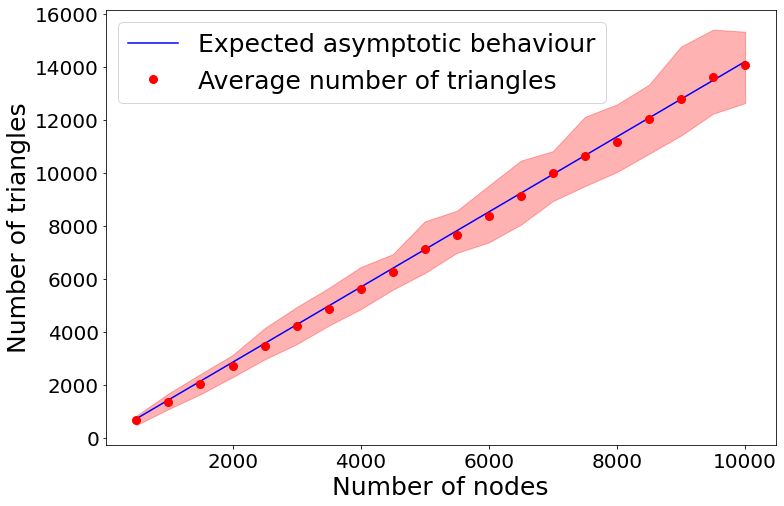

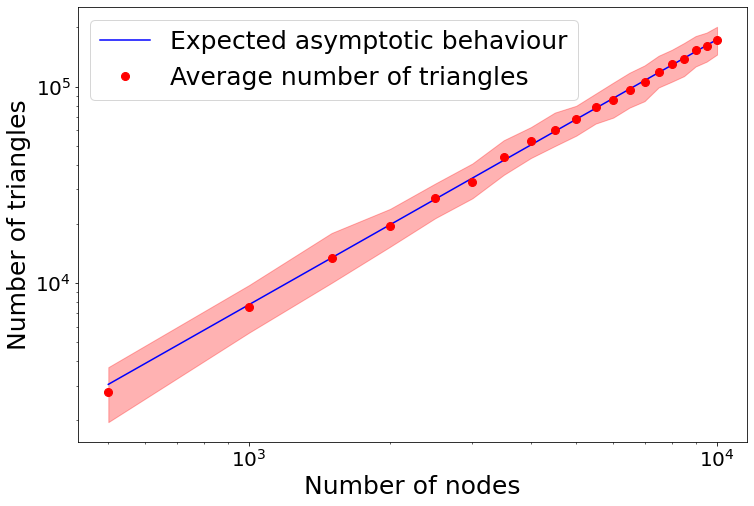

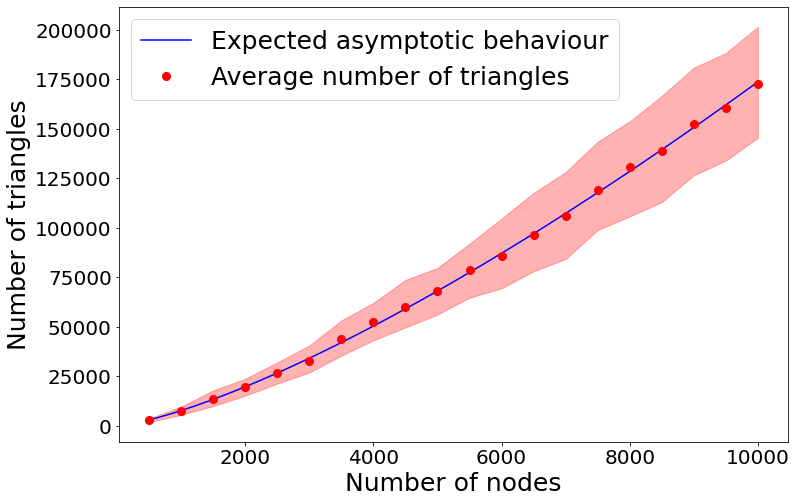

In [23]:
#graphic_data(2.7, 0.4, gtype="CIfill", scaletype="loglog", ndata=100, nstart=500, nstop=10000, nstep=100, graph_range=list(range(500,10001,500)));
#graphic_data(2.7, 0.4, 1.5, gtype="CIfill", scaletype="normal", ndata=100, nstart=500, nstop=10000, nstep=100, graph_range=list(range(500,10001,500)));


#graphic_data(2.1, 0.4 gtype="CIfill", scaletype="loglog", ndata=100, nstart=500, nstop=10000, nstep=100, graph_range=list(range(500,10001,500)));
#graphic_data(2.1, 0.4, gtype="CIfill", scaletype="normal", ndata=100, nstart=500, nstop=10000, nstep=100, graph_range=list(range(500,10001,500)));



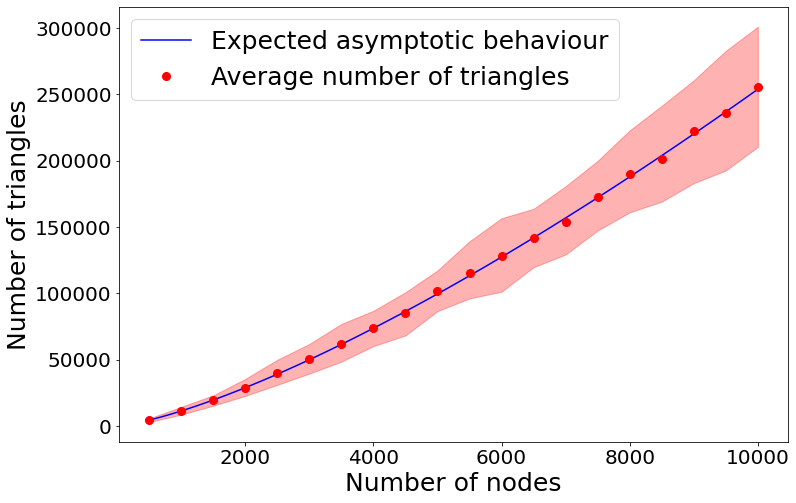

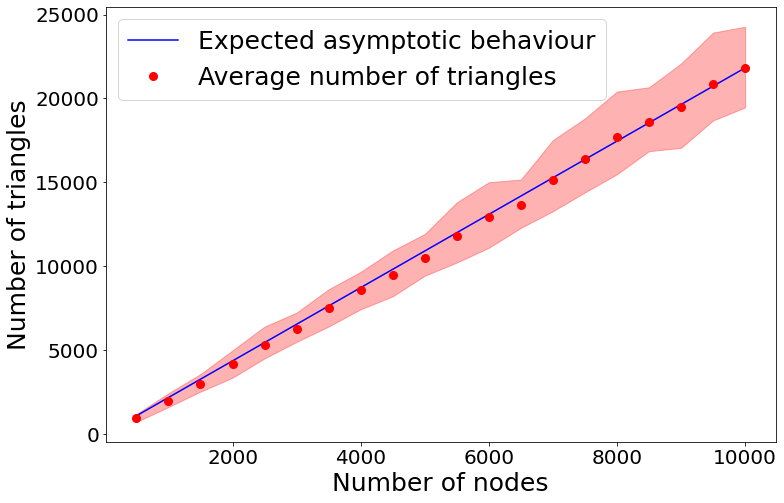

In [4]:
graphic_data(2.1, 0.4, 1.5, gtype="CIfill", scaletype="normal", ndata=100, nstart=500, nstop=10000, nstep=100, graph_range=list(range(500,10001,500)));
graphic_data(2.7, 0.4, 1.5, gtype="CIfill", scaletype="normal", ndata=100, nstart=500, nstop=10000, nstep=100, graph_range=list(range(500,10001,500)));

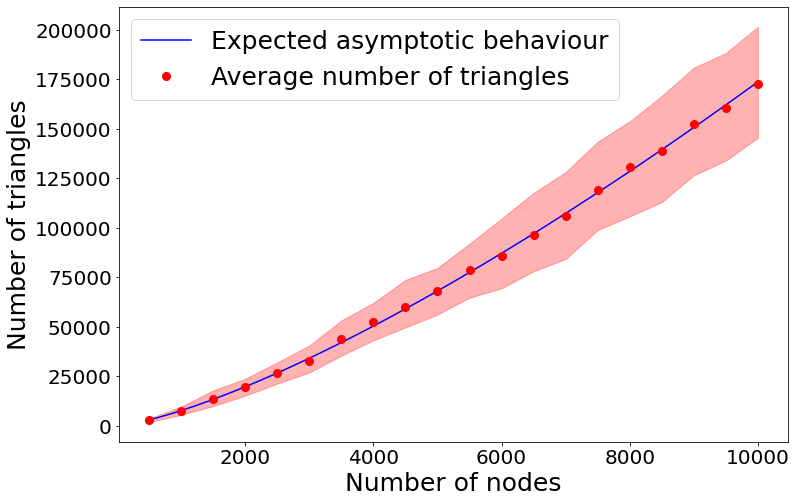

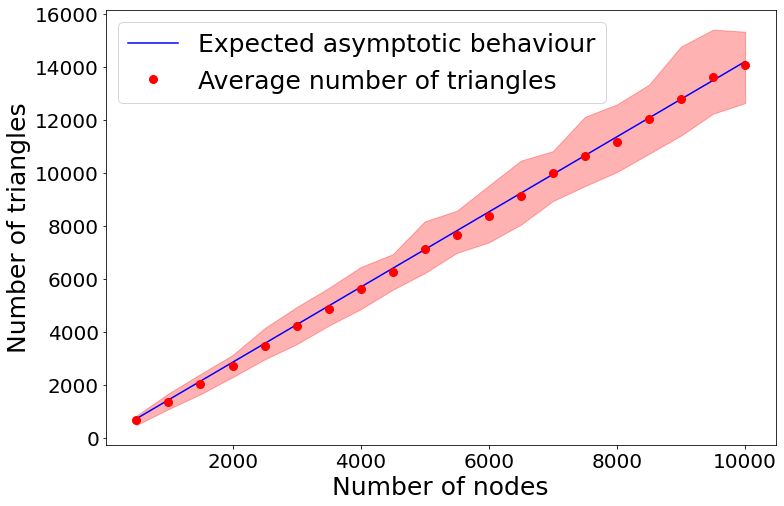

In [5]:
graphic_data(2.1, 0.4, 2.0, gtype="CIfill", scaletype="normal", ndata=100, nstart=500, nstop=10000, nstep=100, graph_range=list(range(500,10001,500)));
graphic_data(2.7, 0.4, 2.0, gtype="CIfill", scaletype="normal", ndata=100, nstart=500, nstop=10000, nstep=100, graph_range=list(range(500,10001,500)));

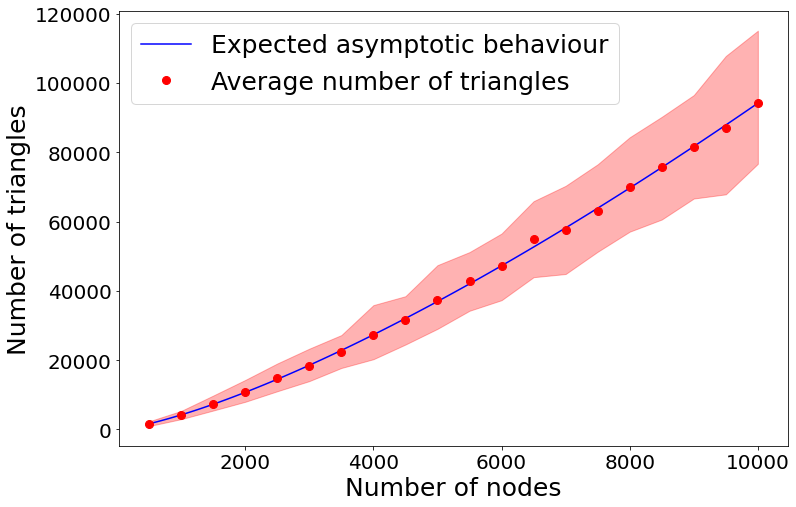

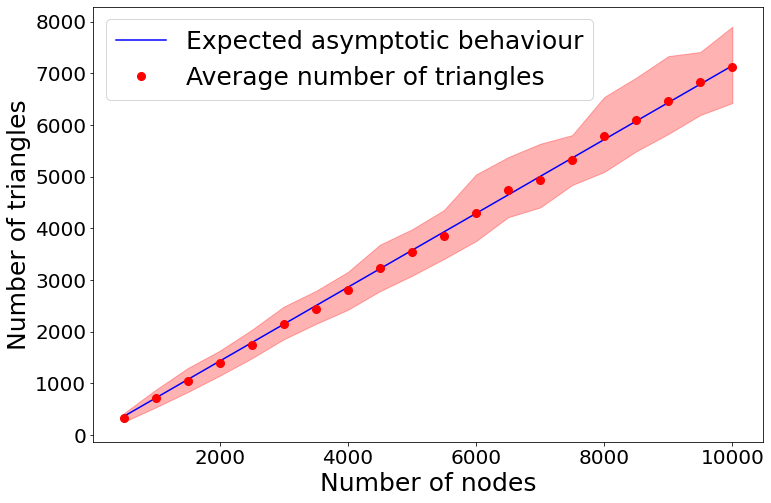

In [6]:
graphic_data(2.1, 0.4, 5.0, gtype="CIfill", scaletype="normal", ndata=100, nstart=500, nstop=10000, nstep=100, graph_range=list(range(500,10001,500)));
graphic_data(2.7, 0.4, 5.0, gtype="CIfill", scaletype="normal", ndata=100, nstart=500, nstop=10000, nstep=100, graph_range=list(range(500,10001,500)));

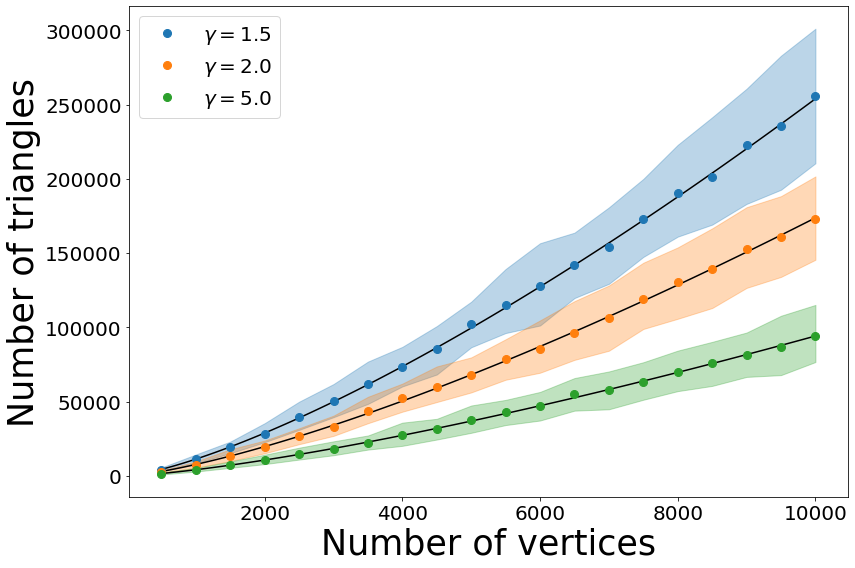

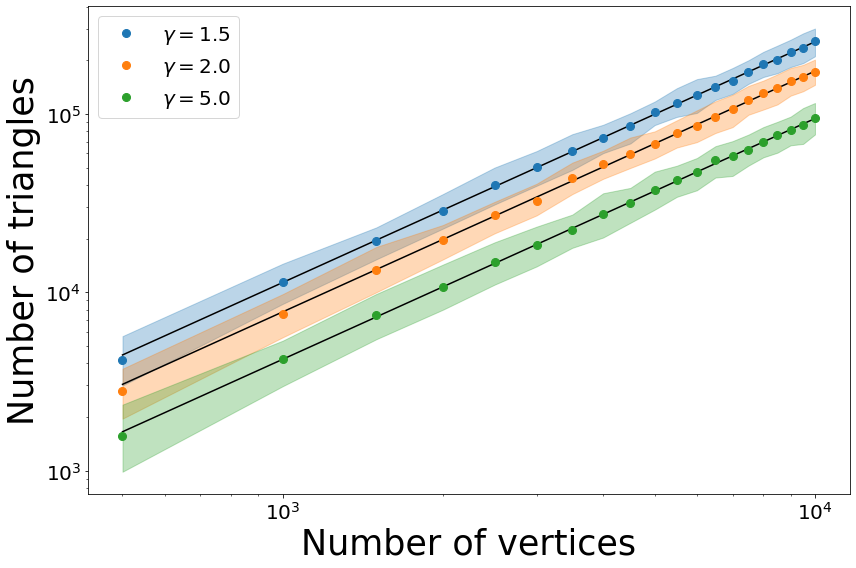

In [13]:
multi_graphic_data(2.1, 0.4, (1.5,2.0,5.0), graph=True, save="normal-ple2.1-scale0.4-gammas", scaletype="normal", graph_range=range(500,10001,500), ndata=100, nstart=500, nstop=10000, nstep=100, opt_tail=30)
multi_graphic_data(2.1, 0.4, (1.5,2.0,5.0), graph=True, save="loglog-ple2.1-scale0.4-gammas", scaletype="loglog", graph_range=range(500,10001,500), ndata=100, nstart=500, nstop=10000, nstep=100, opt_tail=30)

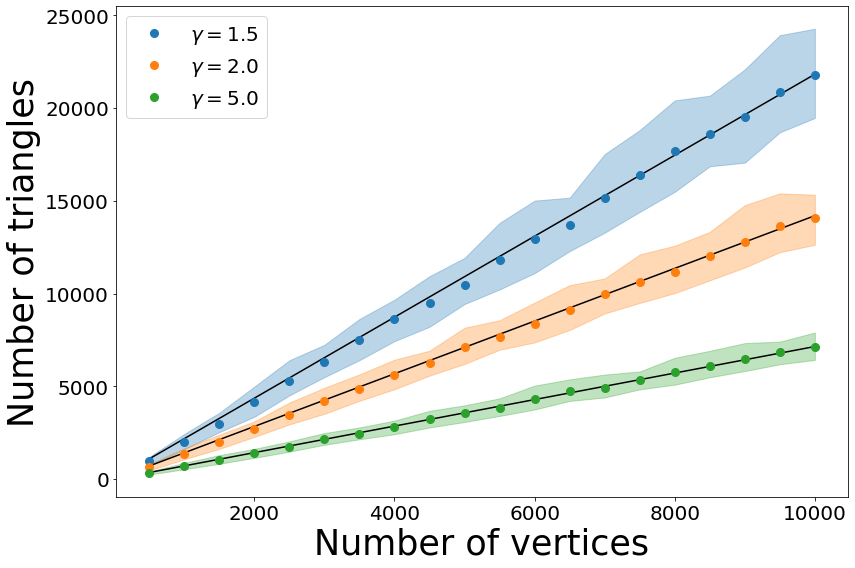

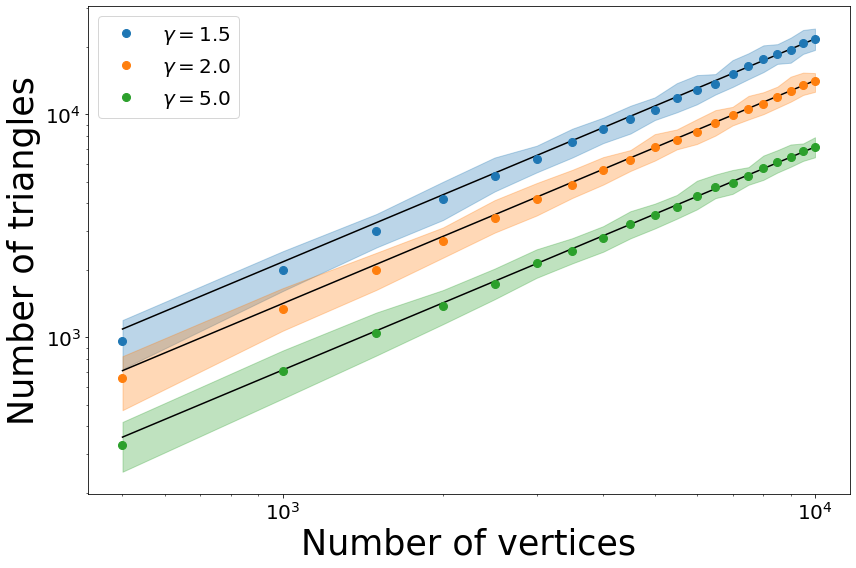

In [14]:
multi_graphic_data(2.7, 0.4, (1.5,2.0,5.0), graph=True, save="normal-ple2.7-scale0.4-gammas", scaletype="normal", graph_range=range(500,10001,500), ndata=100, nstart=500, nstop=10000, nstep=100, opt_tail=30)
multi_graphic_data(2.7, 0.4, (1.5,2.0,5.0), graph=True, save="loglog-ple2.7-scale0.4-gammas", scaletype="loglog", graph_range=range(500,10001,500), ndata=100, nstart=500, nstop=10000, nstep=100, opt_tail=30)